# Ice Floe Tracker data quality and consistency

We examine here whether aspects of the data are consistent year-to-year.

Notes so far:
- There is an issue with the positions for the 2020 data. Are the matches wrong? How are the displacements in stereographic coords so much larger than for the pixel coords?
- Missing rotation rate data



In [1]:
import pandas as pd
import numpy as np
import proplot as pplt

In [4]:
dataloc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

ift_dfs = {}
for year in range(2003, 2021):
    ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))
    ift_dfs[year]['init_classification'] = ift_dfs[year]['init_classification'].fillna('NA')
    ift_dfs[year]['datetime'] = pd.to_datetime(ift_dfs[year].datetime.values)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_70250/1802346071.py:5: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_70250/1802346071.py:5: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_70250/1802346071.py:5: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_70250/1802346071.py:5: DtypeWarning: Columns (33) have mixed types. Specif

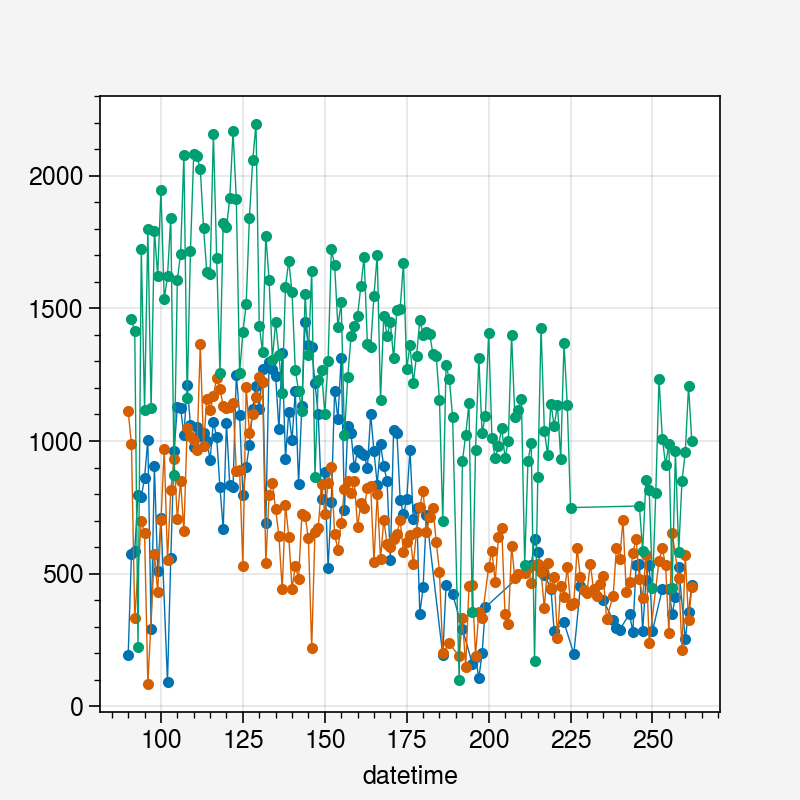

In [82]:
for year in [2003, 2010, 2020]:
    dftest = ift_dfs[year]
    dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'].plot(lw=0.5, marker='.')

How does the number of data points for training the LR model change over time?

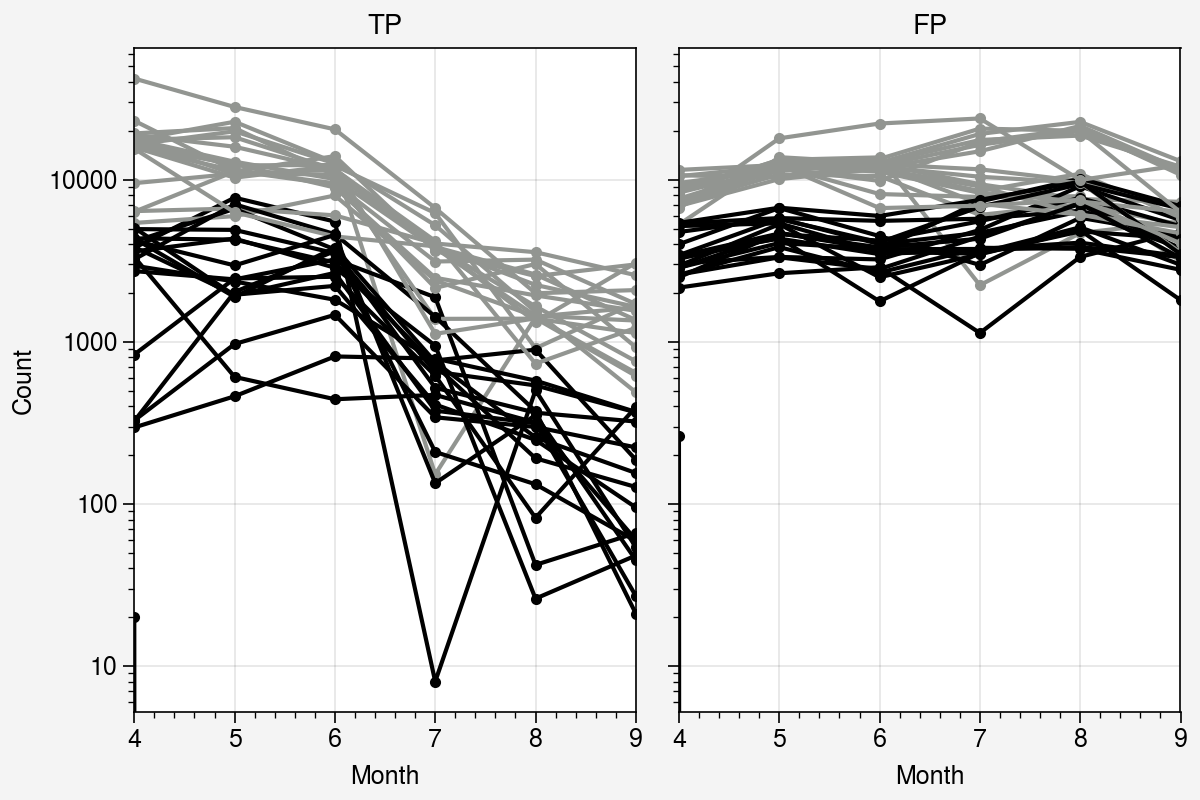

In [21]:
import warnings
warnings.simplefilter('ignore')
fig, axs = pplt.subplots(width=6, height=4, ncols=2, spanx=False)
for cls, ax in zip(['TP', 'FP'], axs):
    for year in ift_dfs:

        summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'lr_classification']
                     ).count()[['floe_id']].pivot_table(index='lr_classification', values='floe_id', columns='datetime').fillna(0)
        summary = summary.loc[:, summary.columns > 3]
        ax.plot(summary.columns, summary.loc['T' in cls,:], marker='.', color='gray')
        
        summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'init_classification']
                     ).count()[['floe_id']].pivot_table(index='init_classification', values='floe_id', columns='datetime').fillna(0)
        summary = summary.loc[:, summary.columns > 3]
        ax.plot(summary.columns, summary.loc[cls,:], marker='.', color='k')

        ax.format(ylabel='Count', title=cls, xlabel='Month')
        ax.format(yscale='log')

We have very few true positives

In [23]:
summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'lr_classification']
                     ).count()[['floe_id']].pivot_table(index='lr_classification', values='floe_id', columns='datetime').fillna(0)


In [24]:
summary

datetime,3,4,5,6,7,8,9
lr_classification,,,,,,,
False,163.0,6652.0,18010.0,22235.0,23891.0,9962.0,12314.0
True,1294.0,42128.0,28122.0,20463.0,6689.0,1993.0,2085.0


In [38]:
def pixel_path_length(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_pixel'] - floe_df['x_pixel'].shift(-1)
    delta_y = floe_df['y_pixel'] - floe_df['y_pixel'].shift(-1)
    return (np.sqrt(delta_x**2 + delta_y**2)).sum()

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)

(array([5.541e+03, 8.720e+02, 9.560e+02, 3.050e+02, 2.740e+02, 1.360e+02,
        1.210e+02, 6.700e+01, 6.200e+01, 4.500e+01, 5.300e+01, 2.100e+01,
        9.000e+00, 9.000e+00, 8.000e+00, 3.000e+00, 1.000e+00, 4.000e+00]),
 array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
        12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 18 artists>)

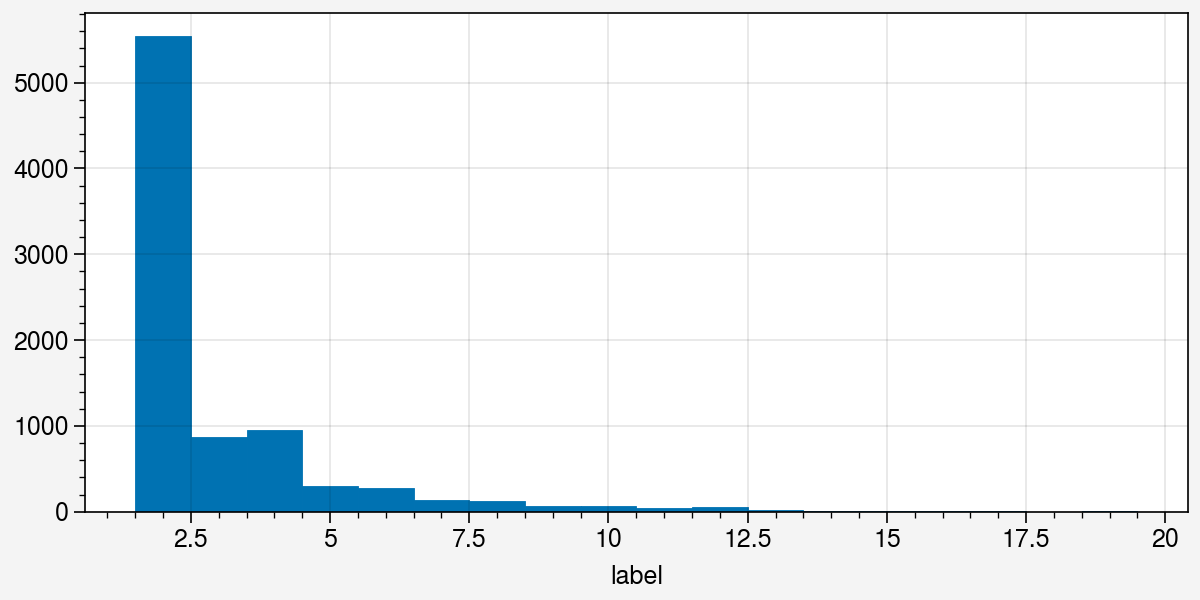

In [34]:
fig, ax = pplt.subplots(width=6, height=3)
ax.hist(ift_dfs[2020].loc[ift_dfs[2020].floe_id != 'unmatched'].groupby('floe_id').count()['label'], bins=np.arange(1.5, 20))

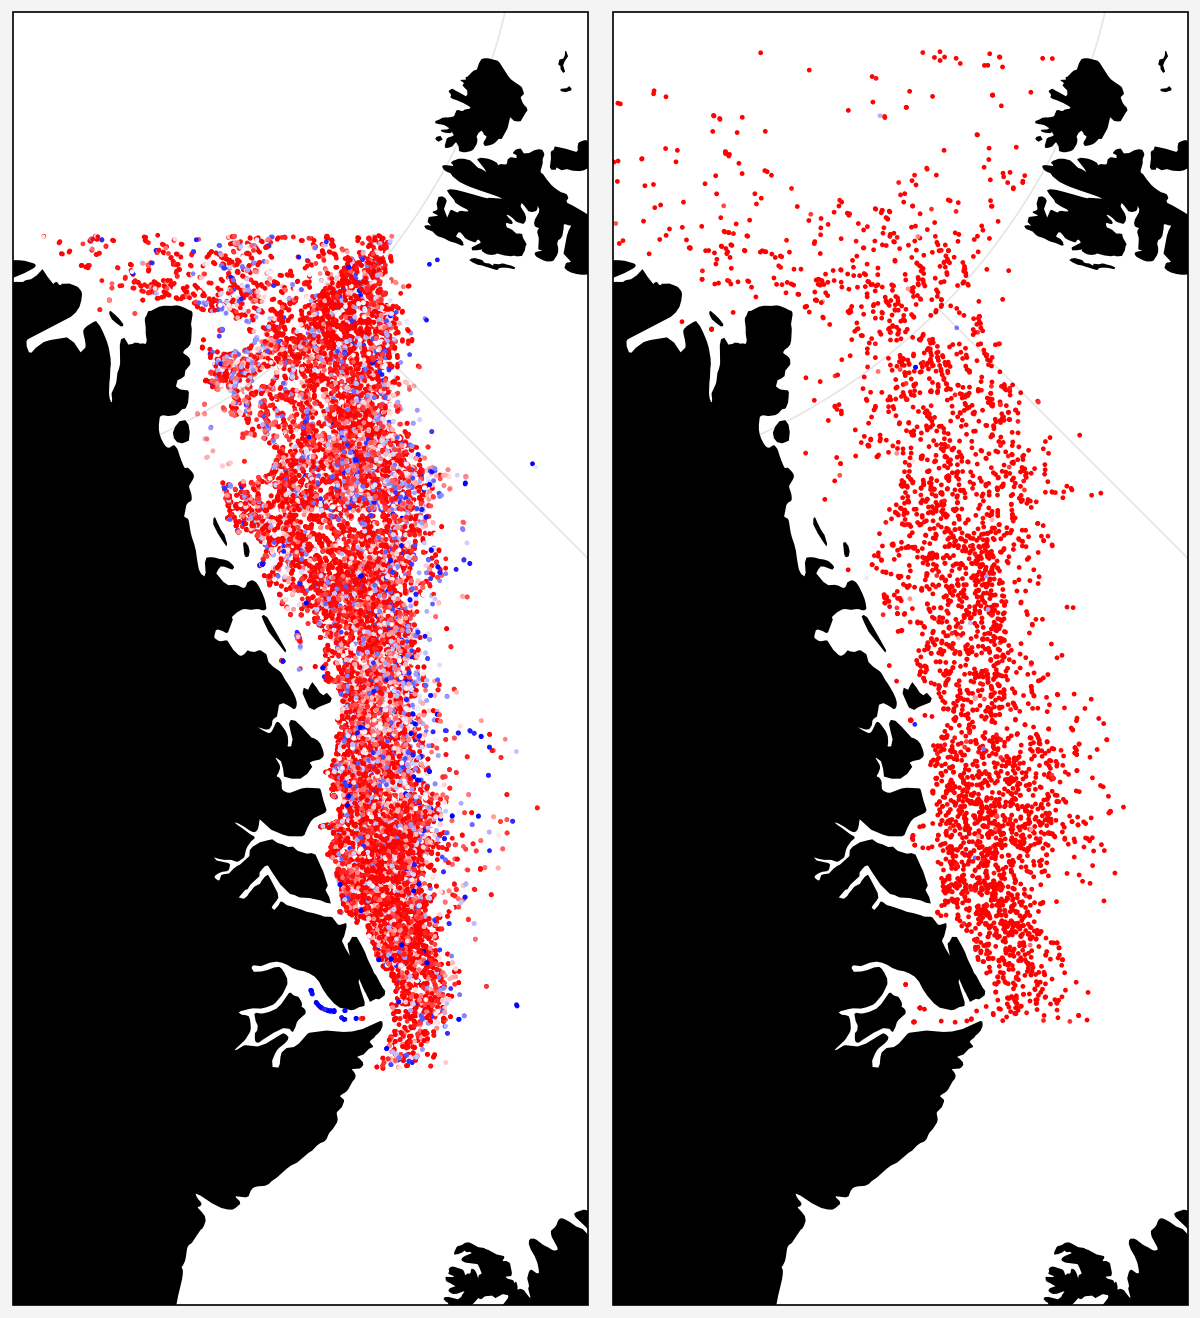

In [73]:
import cartopy.crs as ccrs
pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'

crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=2)
axs.format(land=True, landzorder=0)
axs.set_extent([0.2e6, 1.2e6, -2.5e6, -0.25e6], crs=crs)
for year, ax in zip([2003, 2020], axs):
    df = ift_dfs[year].loc[ift_dfs[year].floe_id != 'unmatched']
    ax.scatter(df.x_stere.values, df.y_stere.values, marker='.', ms=5, c=df.lr_probability, cmap='bwr', transform=crs)


In [42]:
est_speeds = {}
for year in [2010, 2015, 2020]:
    df = ift_dfs[year].loc[ift_dfs[year].floe_id != 'unmatched']
    est_speeds[year] = df.groupby('floe_id').apply(estimated_mean_speed)

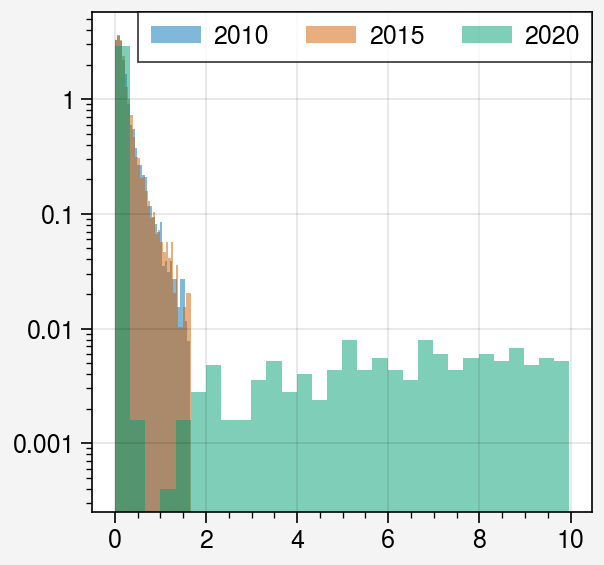

In [49]:
fig, ax = pplt.subplots()
for year in est_speeds:
    ax.hist(est_speeds[year].loc[est_speeds[year] < 10], bins=30, alpha=0.5, label=year, density=True)
ax.legend()
ax.format(yscale='log')

In [67]:
est_speeds[2020].sort_values()[::-1].dropna()

floe_id
2020_00541    325.315
2020_00262    315.153
2020_00218    293.329
2020_00148    293.090
2020_01357    284.001
               ...   
2020_06916      0.000
2020_06917      0.000
2020_06918      0.000
2020_06919      0.000
2020_05298      0.000
Length: 8503, dtype: float64

In [72]:
df.loc[df.floe_id == '2020_00262', ['area', 'perimeter', 'x_stere', 'y_stere', 'col_pixel', 'row_pixel']].diff(axis=0)

,area,perimeter,x_stere,y_stere,col_pixel,row_pixel
7824,NaN,NaN,NaN,NaN,NaN,NaN
8234,-60.0,-4.0,-182671.1,1454348.2,1.944078,2.335406
